# PROJET SD201

## Goal of the project
Establish an optimal number of football player profiles given their physical features and their in-match performances. It could be used as the tool during the transfer market to help recruiters find the football player matching with their expectations.

## Members
Hippolyte Giraud, Valerio Guerrini, Léon Sillano, Romain Darous.

## Plan

# 1. Exploring and cleaning the data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations
import seaborn as sn

## 1.1 Data vizualisation

We open the csv file which contains the dataset and we display a sample of the full raw dataset

In [2]:
# Reading of the dataset
print("Dataset : 2021-2022-football-player-stats.csv")
data = pd.read_csv("DataFoot/2021-2022-football-player-stats.csv", encoding="mac_iceland", sep=";")
data.head()

Dataset : 2021-2022-football-player-stats.csv


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Max Aarons,ENG,DF,Norwich City,Premier League,22.0,2000,34,32,...,0.03,1.41,1.16,0.0,0.06,0.03,5.53,0.47,1.59,22.7
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34.0,1987,34,34,...,0.00,0.06,1.39,0.0,0.03,0.00,6.77,2.02,1.36,59.8
2,3,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22.0,2000,31,29,...,0.00,0.36,1.24,0.0,0.00,0.00,8.76,0.88,0.88,50.0
3,4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29.0,1993,34,34,...,0.03,0.79,2.23,0.0,0.00,0.00,8.87,0.43,0.43,50.0
4,5,Charles Abi,FRA,FW,Saint-…tienne,Ligue 1,22.0,2000,1,1,...,0.00,2.00,0.00,0.0,0.00,0.00,4.00,2.00,0.00,100.0


We display the distribution of the positions

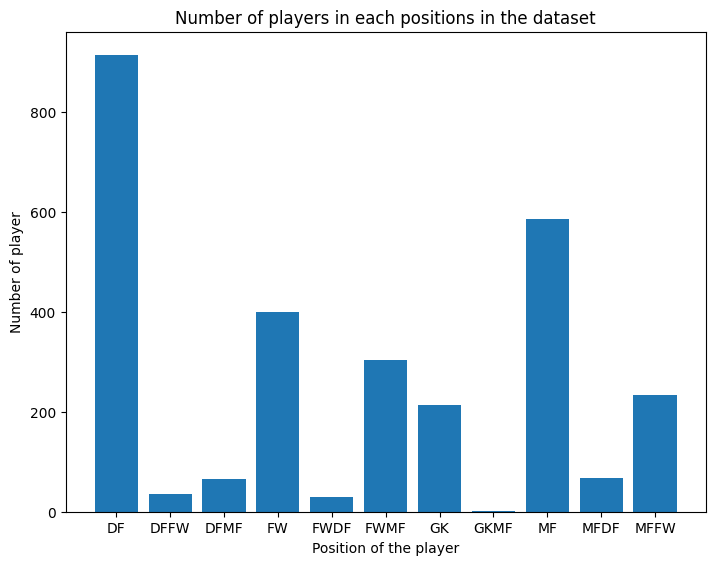

In [3]:
position_distribution = data.groupby('Pos').nunique()[['Player']]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(position_distribution.index.to_list(), position_distribution['Player'].to_list())
plt.xlabel('Position of the player')
plt.title("Number of players in each positions in the dataset")
plt.ylabel('Number of player')
plt.show()

## 1.2 Data cleaning

First, removing the rows where any null value is noticed. One can observe that there is in fact no null value. The dataset is very well full-filled.

In [4]:
data.dropna(inplace = True)
print(data["Pos"].value_counts().sort_values(ascending = False).index[0])
data.shape

DF


(2920, 143)

The histogram above shows that some players have two different positions. For instance, 'DFFW' corresponds to 'DF' (defender) and 'FW' (forwarder).

We decided to attribute only the first position given for these football players.

C:\Users\romai\AppData\Local\Temp\ipykernel_36428\2183629241.py:9: FutureWarning: Series.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  position_distribution.set_axis(position_translation, inplace=True)


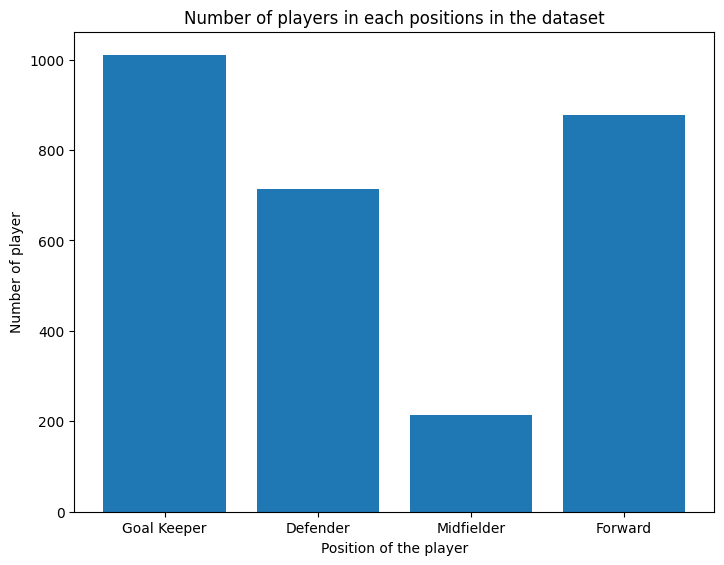

In [5]:
# Simplifying positions
data.replace(['DFFW','DFMF','FWDF','FWMF','GKMF','MFDF','MFFW'],['DF','DF','FW','FW','GK','MF','MF'], inplace = True)

position_abbreviation = ['GK','DF','MF','FW']
position_translation = ['Goal Keeper','Defender','Midfielder','Forward']

# Calculation the new position distribution among football players
position_distribution = data.groupby(['Pos']).nunique()['Player']
position_distribution.set_axis(position_translation, inplace=True)

# Showing the distribution of the new positions in the dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(position_distribution.index, position_distribution)
plt.xlabel('Position of the player')
plt.ylabel('Number of player')
plt.title("Number of players in each positions in the dataset")
plt.show()

Dropping the columns which determine the identity of the players. They are qualitative data that won't help solve our question.<br><br>

We also drop the column whichs deals about the time played in match. Indeed, this feature can be related to other external factors : the age, the level of the player, the injuries he got, etc. It makes it difficult to make a relevant link between this feature and the player's position.
<br><br>
Second, we drop the columns which deal about a rate. These columns are either the result of the ratio of two other columns, or they are equivalent to what we obtain by standardizing and normalizing.

In [6]:
identity_columns_list = ['Rk','Player','Age','Nation','Squad','Comp','Born']
data.drop(identity_columns_list, axis = 1, inplace = True)

time_played_list = ['MP','Starts','Min','90s']
data.drop(time_played_list, axis = 1, inplace = True)

# Drop of ratio columns
def containspercent(list_):
  list_res = []
  for e in list_ :
    if "%" in e:
      list_res.append(e)
  return list_res

ratio_column_list = containspercent(data.columns)
data.drop(ratio_column_list, inplace = True, axis = 1)
print("Columns dropped : ")
print(ratio_column_list)

Columns dropped : 
['SoT%', 'PasTotCmp%', 'PasShoCmp%', 'PasMedCmp%', 'PasLonCmp%', 'TklDri%', 'Press%', 'DriSucc%', 'Rec%', 'AerWon%']


## 1.3 Splitting the data for training and testing

Now that we cleaned the data and we dropped the irrelevant features, we have to split the dataset between a training set and a test set. For each new, set, there will be a **x_set** and a **y_set**, whose meaning is detailed belowed.

In [7]:
# functions which splits the datasets into a train and a test sets.
def x_y_train_test_split(data: pd.DataFrame, percent_train: int = 80):
  data = data.sample(frac = 1)
  nb_rows = data.shape[0]

  x_train = data.iloc[int((1-percent_train/100)*nb_rows):]
  y_train = x_train.copy()

  x_test = data.iloc[:int((1-percent_train/100)*nb_rows)]
  y_test = x_test.copy()
  
  return x_train,y_train, x_test, y_test

x_train_data, y_train_data, x_test_data, y_test_data = x_y_train_test_split(data, percent_train = 80)
print("Number of rows of the train data :",x_train_data.shape[0])
print("Number of rows of the test data :",x_test_data.shape[0])
print("Percentage of the test data :", np.round(x_test_data.shape[0]/data.shape[0]*100,2),"%")
print("Percentage of the train data :", np.round(x_train_data.shape[0]/data.shape[0]*100,2),"%")

Number of rows of the train data : 2337
Number of rows of the test data : 583
Percentage of the test data : 19.97 %
Percentage of the train data : 80.03 %


### 1.3.1 X_data : the features of the model

```x_data``` corresponds to the features of the model :
- ```x_train_data``` corresponds to the features of the training data,
- ```x_test_data``` corresponds to the features of the testing data.

For the training data, we drop ```'Pos'``` column

In [8]:
x_train_data.drop(['Pos'], axis = 1, inplace = True)
x_test_data.drop(['Pos'], axis = 1, inplace = True)

We normalize then standardize the data

In [9]:
def standardize(data:pd.Series):
    stand_data = data.copy()
    stand_data = (stand_data - stand_data.mean())/stand_data.std()
    return stand_data

def normalize(data):
    norm_data = data.copy()
    norm_data = (norm_data - norm_data.min())/(norm_data.max() - norm_data.min())
    return norm_data

x_train_data = standardize(normalize(x_train_data))
x_test_data =  standardize(normalize(x_test_data))

print("Data for training which was cleaned. Ready for clustering !")
x_train_data.head()

Data for training which was cleaned. Ready for clustering !


,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,...,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
2649,-0.460755,-0.741265,-0.493502,-0.641814,-0.730819,-0.919345,-0.159383,-0.220619,-0.21664,-0.215636,...,-0.809183,-0.375053,-0.705409,0.635787,-0.069366,1.867316,-0.174321,-0.173770,0.171922,-0.439264
504,-0.460755,-0.814538,-0.493502,-0.641814,-0.730819,-1.634370,-0.159383,-0.220619,-0.21664,1.149966,...,0.995265,-0.375053,-0.786951,0.263805,-0.069366,-0.246427,-0.174321,1.882376,4.000683,1.070378
1740,-0.337670,-0.608041,-0.405587,0.467892,1.220515,-0.573749,-0.159383,-0.220619,-0.21664,2.258021,...,-0.576109,-0.375053,-0.683170,0.763044,-0.069366,1.098682,-0.174321,0.525211,-0.156835,-0.250022
2720,0.277752,-0.135094,0.096782,1.174068,0.752195,-0.073231,-0.159383,-0.220619,-0.21664,-0.383341,...,0.017855,-0.096599,-0.327351,0.772833,-0.069366,-0.246427,-0.174321,0.139004,-0.268107,-0.331740
575,1.713738,1.230455,1.264789,1.073186,0.752195,-0.108982,-0.159383,-0.220619,-0.21664,-0.473184,...,0.348671,-0.207980,-0.075312,-0.411637,-0.069366,-0.246427,-0.174321,-0.671487,-0.263049,-0.009167


### 1.3.2 Y_data : the expected result of the model

```y_data``` corresponds to the result of the model, we will have :
- ```y_train_data``` which corresponds to the footballer's positions (the result) of the training data
- ```y_test_data``` which corresponds to footballer's positions (the result) of the testing data

For the Y data : we only keep the ```'Pos'``` column

In [10]:
y_train_data = y_train_data[['Pos']]
y_test_data = y_test_data[['Pos']]

We have now four cleaned datasets :

- ```x_train_data``` which is the data containing the features for training our model
- ```y_train_data``` which is the data containing the player's positions (result) for training our model

- ```x_test_data``` which is the data containing the features for testing the accuracy of our model
- ```y_test_data``` which is the data containing the player's positions (result) for testing the accuracy of our model

# 2 Calculate player position using the K-Means algorithm

We can see our problem as a clustering problem, as we want to make four groups of players, each one corresponding to a position. That's why we decided first to apply the K-Mean algorithm with k = 4 to find 4 cluster, and see if they can be associated to positions with a high precision.

## 2.1 K - Means algorithm with all features

We will create 4 clusters using the kmeans algorithm using ```x_train_data```

In [11]:
k = 4 # number of clusters
kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 100).fit(x_train_data)
prediction_x_train_data = kmeans.fit_predict(x_train_data)

print("Result of the prediction with the kmeans algorithm :")
print(prediction_x_train_data)

Result of the prediction with the kmeans algorithm :
[3 3 0 ... 3 1 1]


We have now the prediction given by the k-Mean algorithm contained in ```prediction_x_train_data```. The 4 clusters have arbitrary label in ```{0,1,2,3}```.

The next step is to assign to each cluster a footabller's position by finding the permutation which maximises the precision of the prediction.

### 2.1.1 Finding the best permutation for labelling the clusters




We will find the best permutation which maximises the precision of the prediction on the data ```train_data``` (training data). We explain below we call the best permutation. This is an arbitrary choice.

First of all, we calculate the position number in each cluster for each position. Then, we will deduce the percentage of players by position, by cluster (compared with the total number of player at this position, not in the cluster).This result is obtained by the function ```assign_clusters_position``` in the variable ```position_counter_table```. Then, to assign a position to a cluster, we find the highest percentage, which corresponds a percentage of players with a given position in a particular cluster

The function ```assign_clusters_position``` returns a dictionary, which maps and index of cluster to a position.

The function ```calculate_error``` calculates the error of prediciton of the football player position given the attribution of positions calculated by the function above. It returns an error percentage.

In [12]:
# the function that assigns a position to a cluster. The position chosen is the most common in the cluster.
def assign_clusters_position(y_data, prediction_x_data) :
    positions_considered = y_data["Pos"].unique()
    determined_positions = {} #list of positions alredy attributed
    position_counter_table = pd.DataFrame(index=positions_considered) #table of all the number of positions in each cluster

    # concatenating data and the cluster associated
    y_data_concat = y_data.copy()
    y_data_concat['prediction'] = prediction_x_data

    # determining the position distribution in the cluster
    for i in range (k) :
        # getting the players who are in the cluster i
        y_data_cluster = y_data_concat[y_data_concat['prediction'] == i]

        # getting the number of players  by position in the cluster i
        position_counter = y_data_cluster["Pos"].value_counts().sort_index(ascending = True)
        position_counter_table[str(i)] = position_counter
    
    position_counter_table.fillna(0, inplace = True)
    
    # Getting the correspondant percentage in comparison to the total number of player by position
    for position in positions_considered :
        positions_number = y_data[y_data["Pos"] == position].shape[0]
        position_counter_table.loc[position] = np.round(position_counter_table.loc[position] / positions_number * 100, 2)


    print("Percentage of player by position by cluster\n", position_counter_table)

    # assigning the positions to the cluster
    while (position_counter_table.shape != (0,0)) :
        max_cluster = position_counter_table.max().idxmax()
        max_position = position_counter_table.idxmax()[max_cluster]
        
        determined_positions[int(max_cluster)] = max_position
        position_counter_table.drop([str(max_cluster)], axis = 1, inplace = True)
        position_counter_table.drop([max_position], axis = 0, inplace = True)
    
    return determined_positions # dictionnary that links a cluster index to a position

def calculate_error(position_dict, y_data, prediction_x_data) :    
    # concatenating data and the cluster associated
    y_data_concat = y_data
    y_data_concat['prediction'] = prediction_x_data
    y_data_concat['prediction'] = y_data_concat['prediction'].replace([i for i in range(k)], [position_dict[i] for i in range(k)]) #the index of the cluster is replaced by the position associated

    # filtering mistakes
    error_filter = y_data_concat['prediction'] != y_data_concat['Pos']

    error_percentage = np.round(y_data_concat[error_filter].shape[0] / y_data_concat.shape[0] * 100, 2)

    return error_percentage

position_dict = assign_clusters_position(y_train_data, prediction_x_train_data)
error_percentage = calculate_error(position_dict, y_train_data, prediction_x_train_data)
print("Clusters and the positions assigned", position_dict, "\nPrecision percentage over the training set : " + str(100-error_percentage) + "%")

Percentage of player by position by cluster
         0      1       2      3
DF  15.07   3.80    2.57  78.55
FW   7.41  88.63    3.62   0.33
MF  28.28  30.99    2.84  37.89
GK   0.00   0.00  100.00   0.00
Clusters and the positions assigned {2: 'GK', 1: 'FW', 3: 'DF', 0: 'MF'} 
Precision percentage over the training set : 66.88%


As we can see, the precision is quite high. Something interesting to notice is that the goalkeepers are almost always in the same cluster. This is something intuitive as their role in-game is really different from other players. Let's keep this in mind for later.
As for now, we test our prediction on ```test_data```.

### 2.1.2 Testing the permutation on the test set

In [13]:
prediction_x_test_data = kmeans.fit_predict(x_test_data)

In [14]:
error = calculate_error(position_dict, y_test_data, prediction_x_test_data)

print("The precision of the prediciton (on train_data) for the best permutation is :", 100-error,"%")

The precision of the prediciton (on train_data) for the best permutation is : 25.209999999999994 %


As we can see **the precision is low**, it is due to two factors :
- We have more than 100 columns so the K-means Algorithm given by scipy takes a lot of time to process. We must decrease the input ```n_init``` to get an algorithm which is not too long (actually ```n_init = 100```). We need to decrease the number of columns to have a quicker K-Mean algorithm. In addition, having too much features can be detrimental to the precision.

- Some columns are redundant. Indeed, for example, we have 
  - PasShoCmp : Passes completed (Passes between 5 and 15 yards)
  - PasShoAtt : Passes attempted (Passes between 5 and 15 yards)
  - PasMedCmp : Passes completed (Passes between 15 and 30 yards)
  - PasMedAtt : Passes attempted (Passes between 15 and 30 yards)
  - PasLonCmp : Passes completed (Passes longer than 30 yards)
  - PasLonAtt : Passes attempted (Passes longer than 30 yards

  which are very similar. So we need to keep only relevant columns to have a better prediction.

**We must therefore rethink the way we select features in order to increase our accuracy**.

## 2.2 K-Means algorithm with column selection

### 2.2.1 Finding correlation between features

To determine the most relevant columns, we plot **the autocorrelation matrix** of the columns according to the position attribute.



To do that, let's create 4 new columns ``` ['GK','DF','MF','FW']```, where for each row, one of these attribute would be equal to 1 corresponding of the position of the football player.

In [15]:
from sklearn.preprocessing import OneHotEncoder

train_data =  pd.concat([x_train_data, y_train_data], axis = 1)

position_encoder = OneHotEncoder()
position_encoder.fit(train_data['Pos'].to_numpy().reshape(-1,1))
transformed = position_encoder.transform(train_data['Pos'].to_numpy().reshape(-1,1))

train_data[position_encoder.categories_[0]] = transformed.toarray()
train_data.drop(['Pos'], axis = 1, inplace = True)
train_data.head()


,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,...,PKcon,OG,Recov,AerWon,AerLost,prediction,DF,FW,GK,MF
2649,-0.460755,-0.741265,-0.493502,-0.641814,-0.730819,-0.919345,-0.159383,-0.220619,-0.21664,-0.215636,...,1.867316,-0.174321,-0.173770,0.171922,-0.439264,DF,1.0,0.0,0.0,0.0
504,-0.460755,-0.814538,-0.493502,-0.641814,-0.730819,-1.634370,-0.159383,-0.220619,-0.21664,1.149966,...,-0.246427,-0.174321,1.882376,4.000683,1.070378,DF,1.0,0.0,0.0,0.0
1740,-0.337670,-0.608041,-0.405587,0.467892,1.220515,-0.573749,-0.159383,-0.220619,-0.21664,2.258021,...,1.098682,-0.174321,0.525211,-0.156835,-0.250022,MF,1.0,0.0,0.0,0.0
2720,0.277752,-0.135094,0.096782,1.174068,0.752195,-0.073231,-0.159383,-0.220619,-0.21664,-0.383341,...,-0.246427,-0.174321,0.139004,-0.268107,-0.331740,FW,1.0,0.0,0.0,0.0
575,1.713738,1.230455,1.264789,1.073186,0.752195,-0.108982,-0.159383,-0.220619,-0.21664,-0.473184,...,-0.246427,-0.174321,-0.671487,-0.263049,-0.009167,FW,0.0,1.0,0.0,0.0


In the cell below, we filter columns by using a filter parameter which is the following:

A column is kept if the correlation with one of the attribute position (GK, FW, DF or MF) is more than ```1 - alpha```. This filter allows us to keep the most relevant. The number of columns kept decrease along with the parameter ```alpha``` increases.

Then we display the autocorrelation matrix of the filtered columns :

Initial number of columns : 121
Number of columns after filtering : 28 

Autocorrelation matrix of the filtered columns :


C:\Users\romai\AppData\Local\Temp\ipykernel_36428\2574882145.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = train_data.corr(method='pearson')


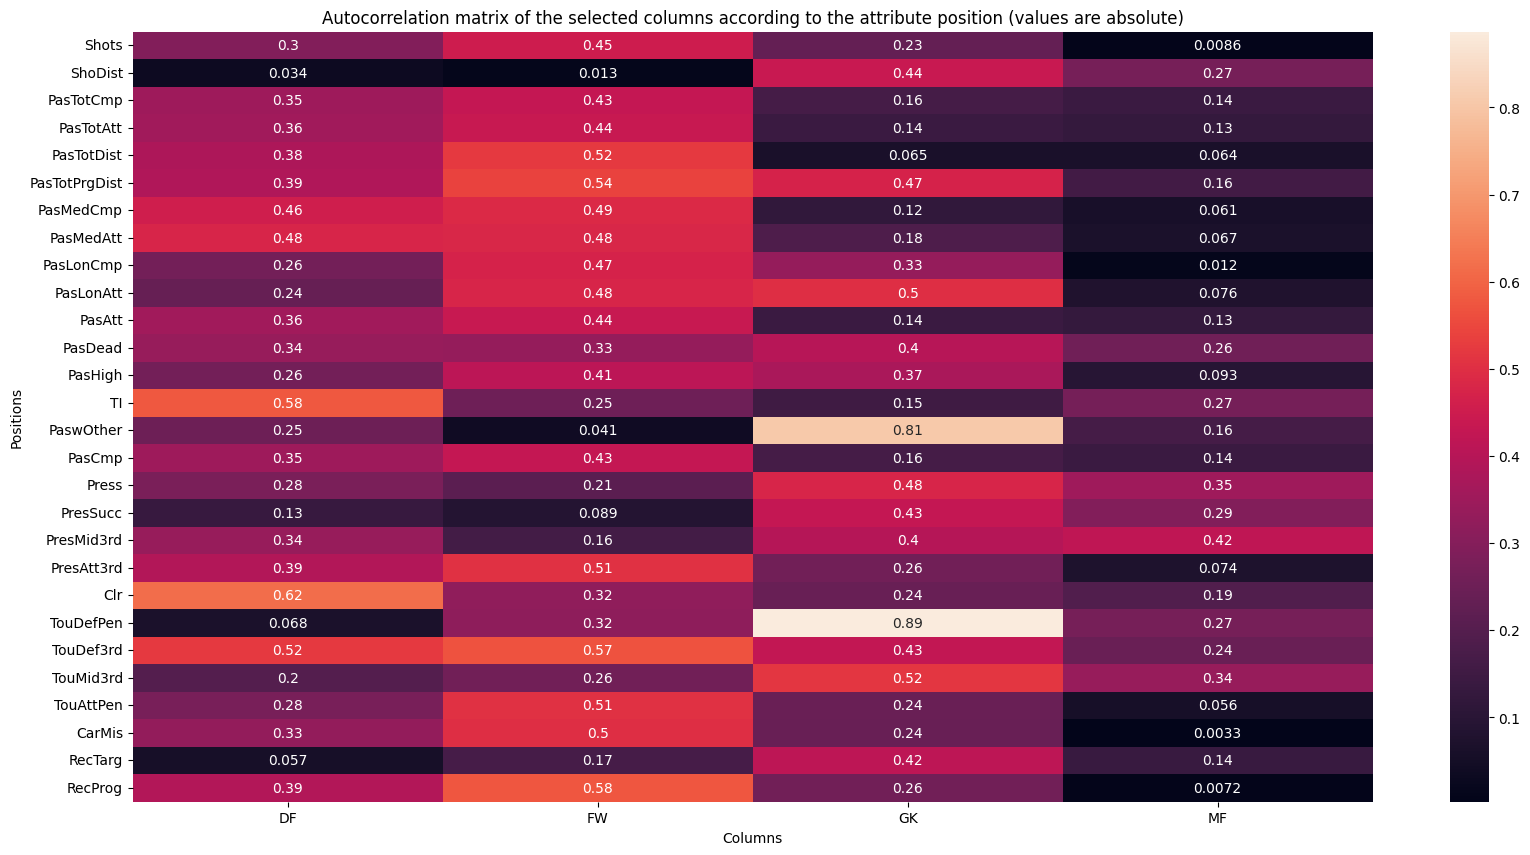

,DF,FW,GK,MF
Shots,0.295144,0.450789,0.231606,0.008581
ShoDist,0.033942,0.012783,0.440109,0.271855
PasTotCmp,0.350992,0.430117,0.163968,0.138576
PasTotAtt,0.355856,0.436650,0.139243,0.125756
PasTotDist,0.382183,0.522616,0.065028,0.064209


In [16]:
corr_df = train_data.corr(method='pearson')

# removing the positions of the features
cf_df = corr_df.loc[:,["DF","FW","GK","MF"]].drop(["DF","FW","GK","MF"])
print("Initial number of columns :",cf_df.shape[0]) # on affihe le nombre de features initiales

alpha = 0.4 # critère de sélection 


cf_df = cf_df.apply(lambda f: abs(f))

# Removing features whose autocorrelation coefficient with all positions is < alpha.
cf_df = cf_df.drop(cf_df[((np.abs(cf_df.DF)) < alpha) & ((np.abs(cf_df.MF)) < alpha) & ((np.abs(cf_df.FW)) < alpha) & ((np.abs(cf_df.GK)) < alpha)].index)

# Displaying the autocorrelation matrix of the filtered columns
print("Number of columns after filtering :", cf_df.shape[0], "\n")
print("Autocorrelation matrix of the filtered columns :")
plt.figure(figsize=(20, 10))
s = sn.heatmap(cf_df, annot=True)
s.set(xlabel='Columns', ylabel='Positions', title = "Autocorrelation matrix of the selected columns according to the attribute position (values are absolute)")
plt.show()
cf_df.head()

We can see that the goal keeper class is **different** from the other classes, in the sense that the autocorrelation of some features are close for the FW, MF, and DF, while they are not for the GK (we can see for example the columns TouDefPen and PaswOther).<br><br>
Thus, it would be interesting to make an algorithm that **distinguishes first the goalkeepers**, and then to be able to make a K-means algorithm on the players in other classes. It resonates with we said about a cluster containing all the goalkeepers earlier. This is a very particular position. A specific treatment could be applied to it.<br><br>
It seems relevant as the goalkeeper has a completely different function on the field in comparison with the other players.

### 2.2.2 Distinguishing goalkeepers with a decision tree algorithm

To distinguish the goalkeepers, we will apply a **decision tree algorithm**.
We display the result with a confusion matrix.

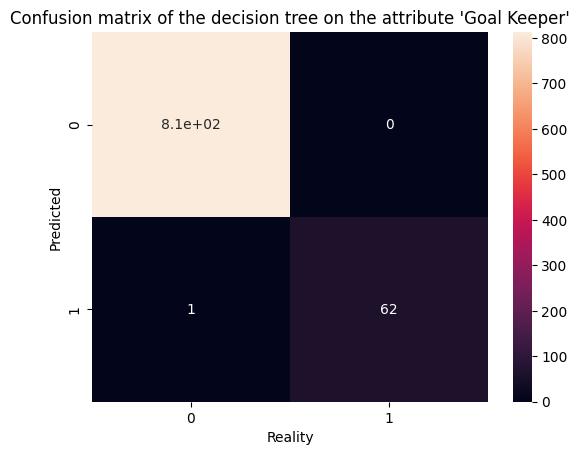

Precision of the classifier : 99.89 %


In [17]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix

data_transformed = data.copy()
position_encoder.fit(data_transformed['Pos'].to_numpy().reshape(-1,1))
transformed = position_encoder.transform(data_transformed['Pos'].to_numpy().reshape(-1,1))

data_transformed[position_encoder.categories_[0]] = transformed.toarray()
data_transformed.drop(['Pos'], axis = 1, inplace = True)

# establishing the train ans test sets.
train, test = train_test_split(data_transformed, test_size = 0.3)
train_x = train.drop(['GK'], axis = 1)
test_x = test.drop(['GK'], axis = 1)
train_y = train.loc[: ,['GK']]
test_y = test.loc[: ,['GK']]

# Creating the decision tree classifier
dt = tree.DecisionTreeClassifier()
dt = dt.fit(train_x, train_y)
dt_pred_y = dt.predict(test_x)

# Displaying the confusion matrix
plt.figure()
conf_mat = confusion_matrix(test_y, dt_pred_y)
s = sn.heatmap(conf_mat, annot=True)
s.set(title = "Confusion matrix of the decision tree on the attribute 'Goal Keeper'")
s.set()
s.set(xlabel='Reality', ylabel='Predicted')
plt.show()

print("Precision of the classifier :", np.round((1-(conf_mat[1][0]+conf_mat[0][1])/(sum(sum(conf_mat))))*100,2),'%')

The precision of the algorithm is almost 100%. It means that it allows to detect a goalkeeper almost surely.

### 2.2.3 Detection other positions using K-Mean Algorithm

Now, we can use the K-Mean algorithm on footballers who have the position FW, MF or DF and **not** GK. We will select only the columns  that verify the ```alpha ``` filter condition.
The value of ```alpha``` will determine the number of columns we want to have in order to optimise the running time of the kmeans algorithm.

First, we filter the data by removing goalkeepers

In [18]:
data_gk_removed = data[data['Pos'] != 'GK']
data_gk_removed.head()

,Pos,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,...,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
0,DF,0.00,0.41,0.06,0.00,0.00,20.5,0.0,0.0,0.0,...,1.84,0.03,1.41,1.16,0.0,0.06,0.03,5.53,0.47,1.59
1,DF,0.06,0.54,0.18,0.11,0.33,18.7,0.0,0.0,0.0,...,0.73,0.00,0.06,1.39,0.0,0.03,0.00,6.77,2.02,1.36
2,MF,0.04,0.66,0.18,0.06,0.20,20.3,0.0,0.0,0.0,...,1.28,0.00,0.36,1.24,0.0,0.00,0.00,8.76,0.88,0.88
3,MF,0.00,0.91,0.21,0.00,0.00,22.6,0.0,0.0,0.0,...,2.07,0.03,0.79,2.23,0.0,0.00,0.00,8.87,0.43,0.43
4,FW,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,2.00,0.00,0.0,0.00,0.00,4.00,2.00,0.00


Now we keep only the most relevant columns by using the ```alpha``` condition filter.

In [19]:
from sklearn.preprocessing import OneHotEncoder

x_train_data, y_train_data, x_test_data, y_test_data = x_y_train_test_split(data_gk_removed, percent_train = 0.8)

x_train_data.drop(['Pos'], axis = 1, inplace = True)
x_test_data.drop(['Pos'], axis = 1, inplace = True)

x_train_data = standardize(normalize(x_train_data))
x_test_data =  standardize(normalize(x_test_data))
y_train_data = y_train_data[['Pos']]
y_test_data = y_test_data[['Pos']]

train_data =  pd.concat([x_train_data, y_train_data], axis = 1)

position_encoder = OneHotEncoder()
position_encoder.fit(train_data['Pos'].to_numpy().reshape(-1,1))
transformed = position_encoder.transform(train_data['Pos'].to_numpy().reshape(-1,1))


train_data[position_encoder.categories_[0]] = transformed.toarray()
train_data.drop(['Pos'], axis = 1, inplace = True)


corr_df = train_data.corr(method='pearson')
cf_df = corr_df.loc[:,["DF","FW","MF"]].drop(["DF","FW","MF"])
print("Initial number of columns :",cf_df.shape[0]) # on affihe le nombre de features initiales

alpha = 0.7 # critère de sélection 

cf_df = cf_df.apply(lambda f: abs(f))
cf_df = cf_df.drop(cf_df[((np.abs(cf_df.DF)) < alpha) & ((np.abs(cf_df.MF)) < alpha) & ((np.abs(cf_df.FW)) < alpha)].index)
print("Number of columns after filtering :", cf_df.shape[0])
relevant_columns = cf_df.index.tolist()
print("")
print("The most relevant columns are : \n")
for i in range(int(len(relevant_columns)/4)) :
  print(relevant_columns[4*i],",", relevant_columns[4*i+1],",",relevant_columns[4*i+2],",",relevant_columns[4*i+3],",")

Initial number of columns : 121
Number of columns after filtering : 29

The most relevant columns are : 

Shots , SoT , PasTotCmp , PasTotAtt ,
PasTotDist , PasTotPrgDist , PasMedCmp , PasMedAtt ,
Pas3rd , PasAtt , PasLive , PasDead ,
PasLow , TI , PasCmp , PresDef3rd ,
PresMid3rd , PresAtt3rd , BlkSh , BlkShSv ,
Tkl+Int , Clr , TouDef3rd , TouMid3rd ,
TouAttPen , CarMis , RecProg , Off ,


We keep only these columns

In [20]:
filtered_dataset_without_gk = data_gk_removed[relevant_columns + ['Pos']]
x_train_data, y_train_data, x_test_data, y_test_data = x_y_train_test_split(filtered_dataset_without_gk, percent_train = 80)
x_train_data.drop(['Pos'], axis = 1, inplace = True)
x_test_data.drop(['Pos'], axis = 1, inplace = True)
x_train_data = standardize(normalize(x_train_data))
x_test_data =  standardize(normalize(x_test_data))
y_train_data = y_train_data[['Pos']]
y_test_data = y_test_data[['Pos']]

Then we apply a kmeans algorithm with k=3 on ```data_gk_removed```

Again, we use the functions ```assign_clusters_position``` and ```calculate_error``` to assign positions to cluster and to calculate the erro percentage of the position prediction.

In [21]:
k = 3
kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 100).fit(x_train_data)
prediction_x_train_data = kmeans.fit_predict(x_train_data)

position_dict = assign_clusters_position(y_train_data, prediction_x_train_data)
error_percentage = calculate_error(position_dict, y_train_data, prediction_x_train_data)

print("The precision of the prediciton (on train_data) for the best permutation is :", 100 - error_percentage,"%")


Percentage of player by position by cluster
         0      1      2
MF  49.72  18.65  31.63
FW   4.67   1.67  93.66
DF  68.81  26.79   4.40
The precision of the prediciton (on train_data) for the best permutation is : 58.9 %


Now we test our prediction on ```test_data```

In [22]:
prediction_x_test_data = kmeans.fit_predict(x_test_data)

position_dict = assign_clusters_position(y_test_data, prediction_x_test_data)
error_percentage = calculate_error(position_dict, y_test_data, prediction_x_test_data)

print("The precision of the prediciton (on train_data) for the best permutation is :", 100 - error_percentage,"%")

Percentage of player by position by cluster
         0      1      2
DF  25.62   5.42  68.97
FW   1.28  94.87   3.85
MF  21.55  33.70  44.75
The precision of the prediciton (on train_data) for the best permutation is : 60.56 %


The precision has increased a lot (it was almost everytime less than 25% for the test set using all features). Separating the goal keeper from other positions and selecting only relevant features helped increase the precision for all the positions. However. It requires to apply to different algorithms. In addition, the precision for positions other than the goalkeeper is still a bit low, as we would like to hit at least 70%.

### 2.2.4 Finding another approach

Lets do a tree decision on an other position and let's see what happens.

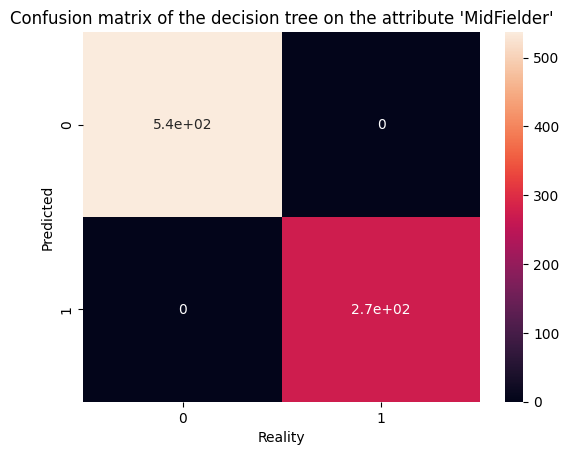

Precision of the classifier : 100.0 %


In [23]:
data_transformed = data_gk_removed.copy()
position_encoder.fit(data_transformed['Pos'].to_numpy().reshape(-1,1))
transformed = position_encoder.transform(data_transformed['Pos'].to_numpy().reshape(-1,1))

data_transformed[position_encoder.categories_[0]] = transformed.toarray()
data_transformed.drop(['Pos'], axis = 1, inplace = True)

train, test = train_test_split(data_transformed, test_size = 0.3)
train_x = train.drop(['MF'], axis = 1)
test_x = test.drop(['MF'], axis = 1)
train_y = train.loc[: ,['MF']]
test_y = test.loc[: ,['MF']]

dt = tree.DecisionTreeClassifier()
dt = dt.fit(train_x, train_y)
dt_pred_y = dt.predict(test_x)


plt.figure()
conf_mat = confusion_matrix(test_y, dt_pred_y)
s = sn.heatmap(conf_mat, annot=True)
s.set(title = "Confusion matrix of the decision tree on the attribute 'MidFielder'")
s.set()
s.set(xlabel='Reality', ylabel='Predicted')
plt.show()

print("Precision of the classifier :", np.round((1-(conf_mat[1][0]+conf_mat[0][1])/(sum(sum(conf_mat))))*100,2),'%')

On the cell above, we saw that the efficiency of the **decisionnal tree** is incredible. This discover pushed us to try to apply another algorithm : the **Random Forest algorithm**.

# 3 Random Forest algorithm

We saw that the decisionnal tree on goalkeepers and midfielders were very efficient. That's why the Random Forest algorithm could be a very intersting idea to try in order to predict player position.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)

x_train_data, y_train_data, x_test_data, y_test_data = x_y_train_test_split(data, percent_train = 80)

x_train_data.drop(['Pos'], axis = 1, inplace = True)
x_test_data.drop(['Pos'], axis = 1, inplace = True)

x_train_data = standardize(normalize(x_train_data))
x_test_data =  standardize(normalize(x_test_data))
y_train_data = y_train_data[['Pos']]
y_test_data = y_test_data[['Pos']]

x_train_data = pd.DataFrame(x_train_data).fillna(0)
clf.fit(x_train_data, y_train_data)

print("Precision of the prediction of the random forest classifier :", np.round(clf.score(x_test_data,y_test_data)*100,1),"%")

C:\Users\romai\AppData\Local\Temp\ipykernel_36428\2485788455.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_data, y_train_data)


Precision of the prediction of the random forest classifier : 78.4 %


The precision of the prediction is around 80%, which is great ! We will keep this algorithm to predict the position of the player.